In [1]:
library(Seurat)
library(CellChat) 
library(patchwork) 
library(ggpubr)
library(circlize)
options(stringsAsFactors = FALSE)
library(tidyr) ## gather
library(tibble)
library(ggsankey)
source("./chat.fun.R")

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinfo

In [2]:
## Load the results (cellchat.extract.organize.ipynb)
load(file = "./load_files/LR_combined_results.Rdata") ## tsnedata, newmats, 

In [3]:
## Set interaction pairs
pc_clusters <- c("PC FGF17", "PC NKX2-1", "PC RSPO3", "PC TTR")
rgc_clusters <- c("GE NERG-early", "FC NERG-early", "OcC NERG-early")
cls_pairs <- expand.grid(rgc_clusters, pc_clusters) %>%
                mutate(Var1 = as.character(Var1), Var2 = as.character(Var2)) %>%
                subset(Var1 != Var2) %>%
        mutate(pair = paste0(Var2, "|", Var1)) %>%
        .$pair


          1           2           3           4           5           6 
"#440154FF" "#482878FF" "#3E4A89FF" "#31688EFF" "#26828EFF" "#1F9E89FF" 
          7           8           9          10 
"#35B779FF" "#6DCD59FF" "#B4DE2CFF" "#FDE725FF" 


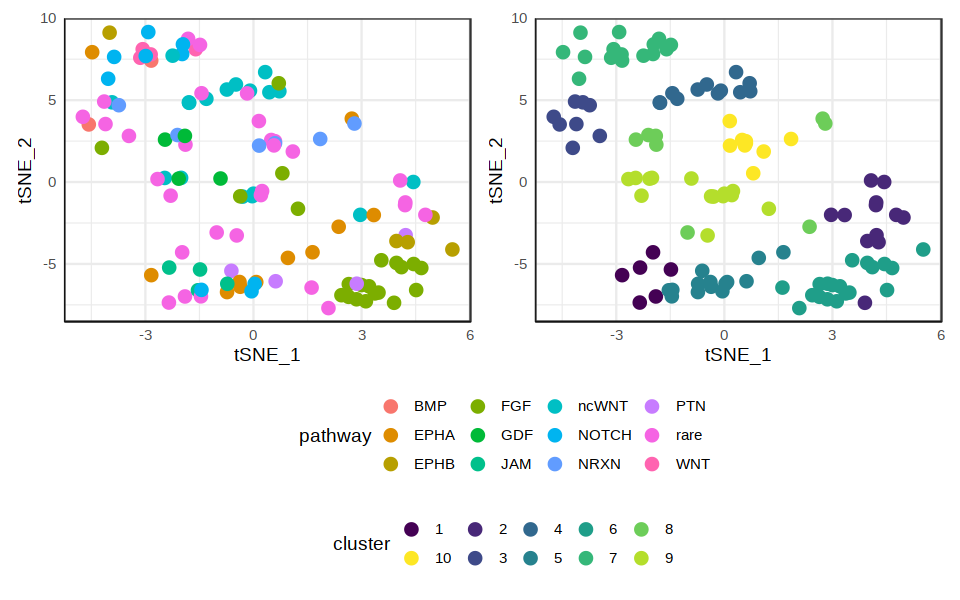

In [4]:
## Visualize the pathways and clusters of the pairs on tSNE
p2 <- ggplot(tsnedata, aes_string(x = "tSNE_1", y = "tSNE_2", color = "pathway")) +
                geom_jitter(size = 3.5, shape = 16) +
                theme_bw() +
                theme(axis.line = element_line(size = 0.2), axis.ticks = element_line(0.2), 
                      legend.position = "bottom")
cls_ord <- tsnedata$cluster %>%
                unique() %>%
                as.numeric() %>% sort() %>% as.character()
cls_cols <- viridis::viridis(length(cls_ord)) %>% setNames(., cls_ord)
print(cls_cols)
p3 <- ggplot(tsnedata, aes_string(x = "tSNE_1", y = "tSNE_2", color = "cluster")) +
                geom_jitter(size = 3.5, shape = 16) +
                scale_color_manual(values = cls_cols) +
                theme_bw() +
                theme(axis.line = element_line(size = 0.2), axis.ticks = element_line(0.2), 
                      legend.position = "bottom")
pcbn <- patchwork::wrap_plots(list(p2, p3), nrow = 1, ncol = 2, guides = "collect") & 
                theme(legend.position = "bottom")
options(repr.plot.width=8, repr.plot.height=5)
pcbn

In [5]:
pdf(paste0("./report/", "LR_TSNE_v2.pdf"), width = 8, height = 5, useDingbats = FALSE)
print(pcbn)
dev.off()

png 
  2

[1] 12

Warning message:
“Removed 953 rows containing missing values (geom_point).”


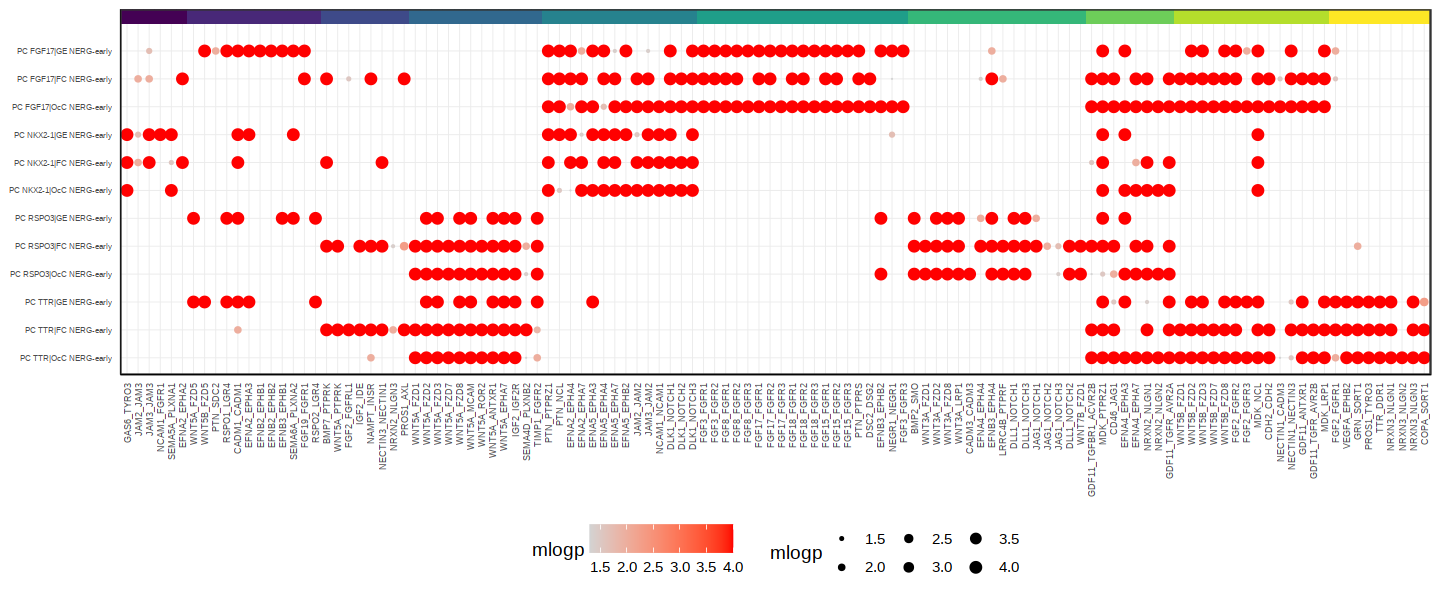

In [6]:
## Plot all pairs
p_ord <- split(tsnedata$pairs, tsnedata$cluster) %>%
                .[cls_ord] %>% unlist()
dotdata <- -log10(newmats) %>%
                as.matrix() %>%
                reshape2::melt() %>% 
                setNames(., c("ID", "cluster_pair", "mlogp")) %>%
                mutate(mlogp = MinMax(mlogp, min = 0, max = 4)) %>%
                mutate(ID = factor(as.character(ID), levels = p_ord)) %>%
                mutate(cluster_pair = factor(as.character(cluster_pair), levels = rev(cls_pairs)))
dotdata$mlogp[dotdata$mlogp == 0] <- NA
anno <- data.frame(cluster = tsnedata$cluster[match(p_ord, tsnedata$pairs)],
                x_left = 0:(length(p_ord)-1),
                x_right = 1:length(p_ord),
                y_min = 13,
                y_max = 13.5,
                stringsAsFactors = FALSE) %>%
                mutate(fill = cls_cols[cluster]) %>%
                mutate(x_left = x_left + 0.5, x_right = x_right + 0.5)
pdot <- ggplot(dotdata, aes_string(y = "cluster_pair", x = "ID", size = "mlogp", color = "mlogp"))+
                geom_point(shape = 16)+
                annotate("rect", xmin = anno$x_left, xmax = anno$x_right, 
                         ymin = anno$y_min, ymax = anno$y_max, fill = anno$fill) +
                scale_size(range = c(0, 3)) +
                scale_color_gradient(low = "lightgrey", high = "red") +
                scale_fill_identity() +
                theme_bw()+
                ##RotatedAxis() + 
                theme(panel.grid = element_line(size = 0.2), axis.line = element_line(size = 0.2), 
                      axis.ticks = element_line(0.2), legend.position = "bottom", 
                      axis.text.x = element_text(size = rel(0.6), angle = 90, hjust = 1, vjust = 0.5), 
                      axis.title = element_blank(), axis.text.y = element_text(size = rel(0.5)))
length(unique(dotdata$cluster_pair))
options(repr.plot.width=12, repr.plot.height=5, res = 300)
pdot

In [7]:
pdf(paste0("./report/", "LR_all_interactions_v2.pdf"), width = 10, height = 4, useDingbats= FALSE)
print(pdot)
dev.off()

Warning message:
“Removed 953 rows containing missing values (geom_point).”


png 
  2

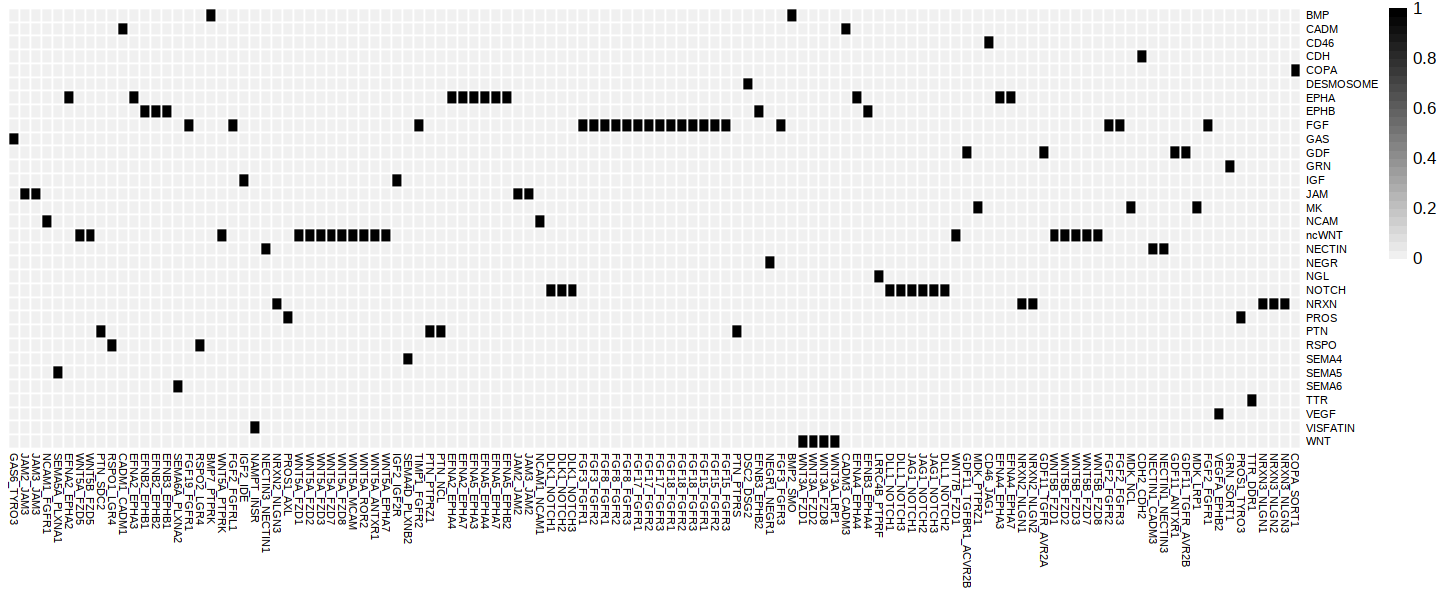

In [8]:
## Plot interaction pair annotation
mmdata <- tsnedata[match(p_ord, tsnedata$pairs), ] %>%
                mutate(ID = factor(as.character(pairs), levels = p_ord))

annomat <- matrix(0, nrow = length(unique(tsnedata$rawpath)), ncol = length(p_ord), 
                  dimnames = list(levels(as.factor(tsnedata$rawpath)), p_ord))
for (i in 1:nrow(tsnedata)){
    annomat[tsnedata$rawpath[i], tsnedata$pairs[i]] <- 1
}
pheatmap::pheatmap(annomat, cluster_rows =FALSE, cluster_cols = FALSE, 
                   color = colorRampPalette(c("#f0f0f0", "#000000"))(30), 
                   border_color = "white", show_rownames = TRUE, 
                   show_colnames = TRUE, fontsize_col = 6, fontsize_row = 6)


png 
  2

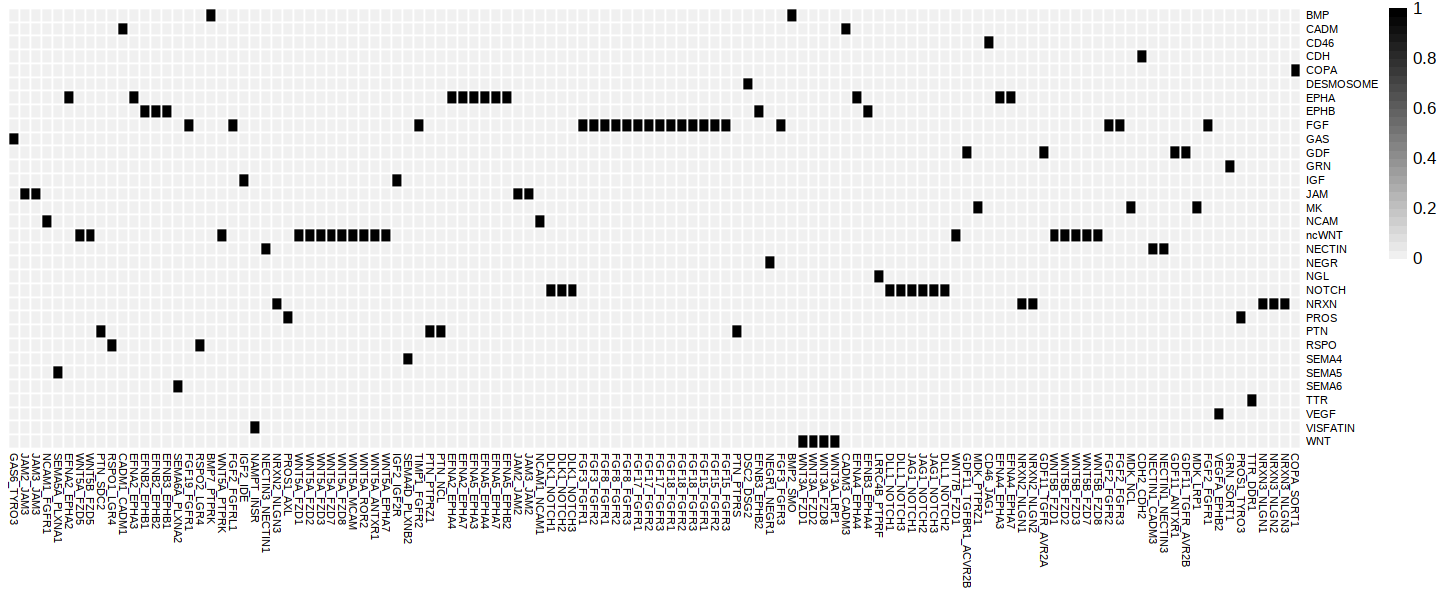

In [9]:
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}


xx <- pheatmap::pheatmap(annomat, cluster_rows =FALSE, cluster_cols = FALSE, 
                   color = colorRampPalette(c("#f0f0f0", "#000000"))(30), 
                   border_color = "white", show_rownames = TRUE, show_colnames = TRUE, 
                   fontsize_col = 6, fontsize_row = 6)
save_pheatmap_pdf(x = xx, filename = paste0("./report/", "LR_all_interactions_annotation_v2.pdf"), 
                  width=10, height=4)

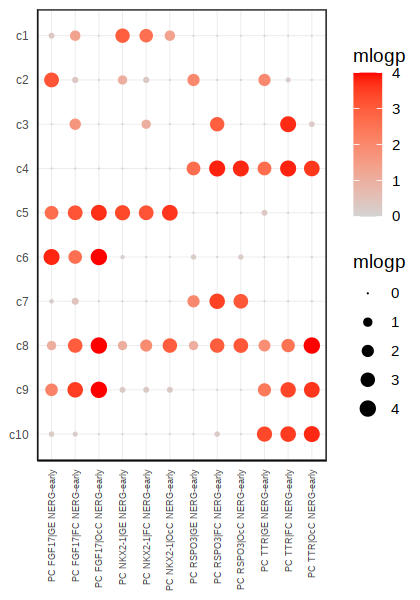

In [10]:
## Plot eigengenes (average p values)
newmlp <- MinMax(-log10(newmats), min = 0, max = 4)
avgdata <- by(newmlp, paste0("c", tsnedata$cluster), colMeans) %>%
                do.call(rbind, .) %>%
                as.matrix() %>%
                reshape2::melt() %>% 
                setNames(., c("ID", "cluster_pair", "mlogp")) %>%
                mutate(cluster_pair = factor(as.character(cluster_pair), levels = cls_pairs)) %>%
                mutate(ID = factor(as.character(ID), 
                                   levels = paste0("c", sort(as.numeric(unique(tsnedata$cluster)), 
                                                             decreasing = TRUE))))
pdot_eigen <- ggplot(avgdata, aes_string(x = "cluster_pair", y = "ID", size = "mlogp", color = "mlogp"))+
                geom_point(shape = 16)+
                scale_size(range = c(0, 4)) +
                scale_color_gradient(low = "lightgrey", high = "red") +
                scale_fill_identity() +
                theme_bw()+
                ##RotatedAxis() + 
                theme(panel.grid = element_line(size = 0.2), 
                      axis.line = element_line(size = 0.2), 
                      axis.ticks = element_line(0.2), legend.position = "right", 
                      axis.text.x = element_text(size = rel(0.6), angle = 90, hjust = 1, vjust = 0.5), 
                      axis.title = element_blank(), axis.text.y = element_text(size = rel(0.8)))

options(repr.plot.width=3.5, repr.plot.height=5, res = 600)
pdot_eigen

In [11]:
pdf(paste0("./report/", "LR_all_interactions_mes_v2.pdf"), width = 3.75, height = 5, useDingbats= FALSE)
print(pdot_eigen)
dev.off()

png 
  2

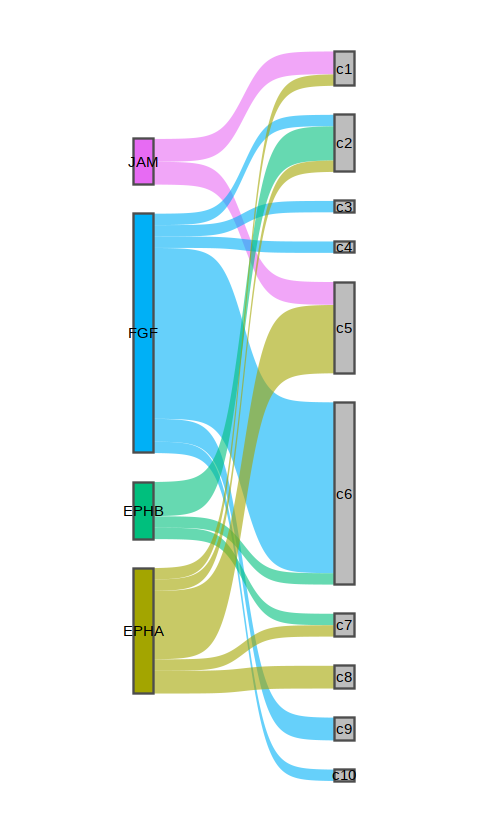

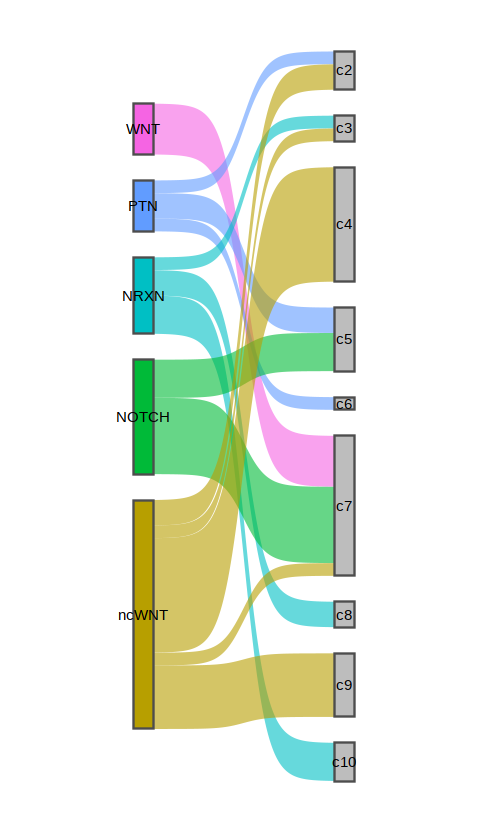

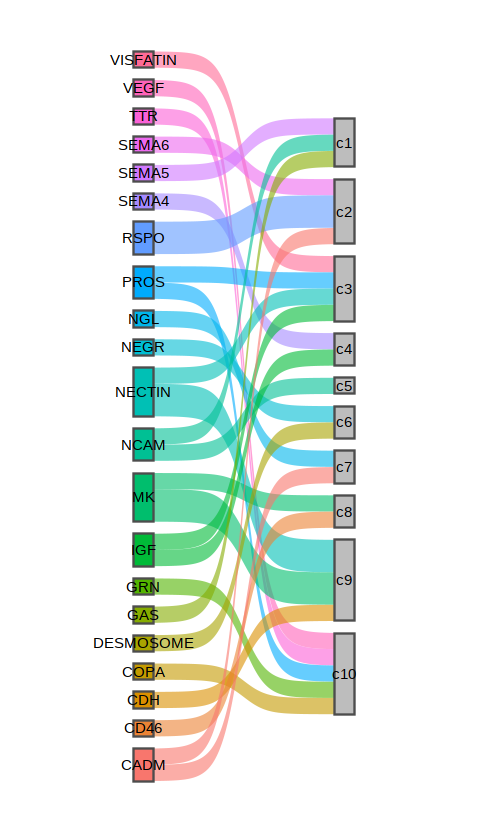

In [12]:
## Sankey plots showing the relationship between pathways and modules
cbn_meta <- tsnedata[, c("cluster", "pathway", "rawpath")]
rownames(cbn_meta) <- tsnedata$pairs
cbn_meta$cluster <- paste0("c", cbn_meta$cluster)

all_paths <- table(cbn_meta$pathway)
all_cls <- gsub("c", "", cbn_meta$cluster) %>%
                unique() %>%
                as.numeric() %>% sort() %>% paste0("c", .)

path_list <- list(p1 = c("COLLAGEN", "EPHA", "EPHB", "FGF", "JAM"), 
                p2 = c("LAMININ", "ncWNT", "NOTCH", "NRXN", "PTN", "WNT"), 
                p3 = c("rare"))
s1 <- plot_ggsankey(meta = cbn_meta[cbn_meta$pathway %in% path_list$p1, ], 
                    x_col = "pathway", 
                    x_ord = path_list$p1, 
                    next_col = "cluster", 
                    next_ord = intersect(all_cls, unique(cbn_meta$cluster[cbn_meta$pathway %in% path_list$p1])) %>% 
                    rev(), 
                    type = "sankey", space= 0.01,  width = 0.1)
s2 <- plot_ggsankey(meta = cbn_meta[cbn_meta$pathway %in% path_list$p2, ], 
                    x_col = "pathway", x_ord = path_list$p2, next_col = "cluster", 
                    next_ord = intersect(all_cls, unique(cbn_meta$cluster[cbn_meta$pathway %in% path_list$p2])) %>% 
                    rev(), type = "sankey", space= 0.01,  width = 0.1)
s3 <- plot_ggsankey(meta = cbn_meta[cbn_meta$pathway %in% path_list$p3, ], 
                    x_col = "rawpath", x_ord = NULL, next_col = "cluster", 
                    next_ord = intersect(all_cls, unique(cbn_meta$cluster[cbn_meta$pathway %in% path_list$p3])) %>% 
                    rev(), type = "sankey", space= 0.01,  width = 0.1)
options(repr.plot.width=4, repr.plot.height=7, res = 300)
s1
s2
s3

In [13]:
pdf(paste0("./report/", "LR.sankey.full_v2.pdf"), width = 10, height = 10)
print(s1)
print(s2)
print(s3)
dev.off()

png 
  2

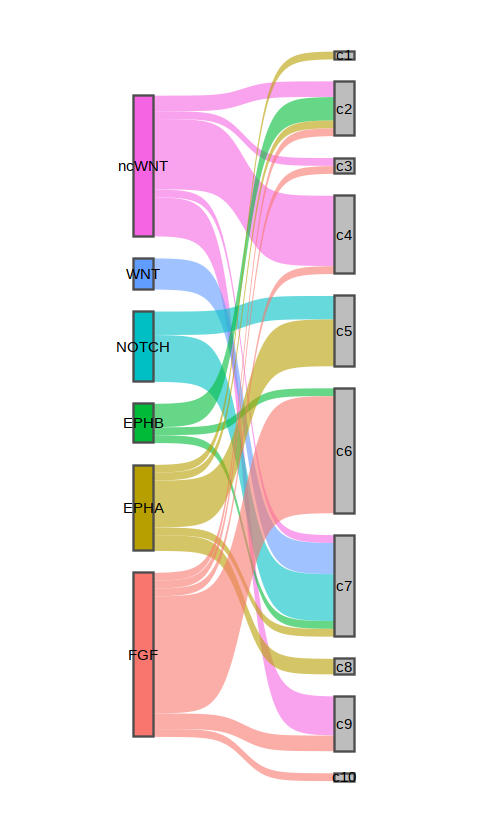

In [14]:
## Plot Sankey for just some selected pathways
sel_paths <- c("FGF", "EPHA", "EPHB", "NOTCH", "WNT", "ncWNT")

cbn_meta <- tsnedata[, c("cluster", "pathway", "rawpath")]
rownames(cbn_meta) <- tsnedata$pairs
cbn_meta$cluster <- paste0("c", cbn_meta$cluster)
cbn_meta <- cbn_meta[cbn_meta$rawpath %in% sel_paths, ]
all_cls <- gsub("c", "", cbn_meta$cluster) %>%
                unique() %>%
                as.numeric() %>% sort() %>% paste0("c", .)

ss <- plot_ggsankey(meta = cbn_meta, x_col = "rawpath", 
                    x_ord = sel_paths, next_col = "cluster", 
                    next_ord = rev(all_cls), type = "sankey", space= 0.01,  width = 0.1)
options(repr.plot.width=4, repr.plot.height=7, res = 300)
ss

In [15]:
pdf(paste0("./report/", "LR.sankey.selected_v2.pdf"), width = 4, height = 7)
print(ss)
dev.off()

png 
  2

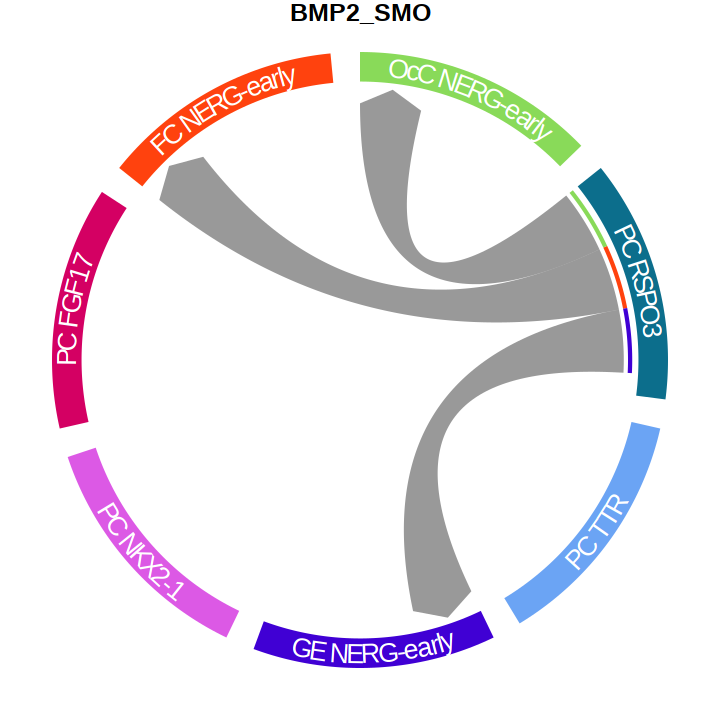

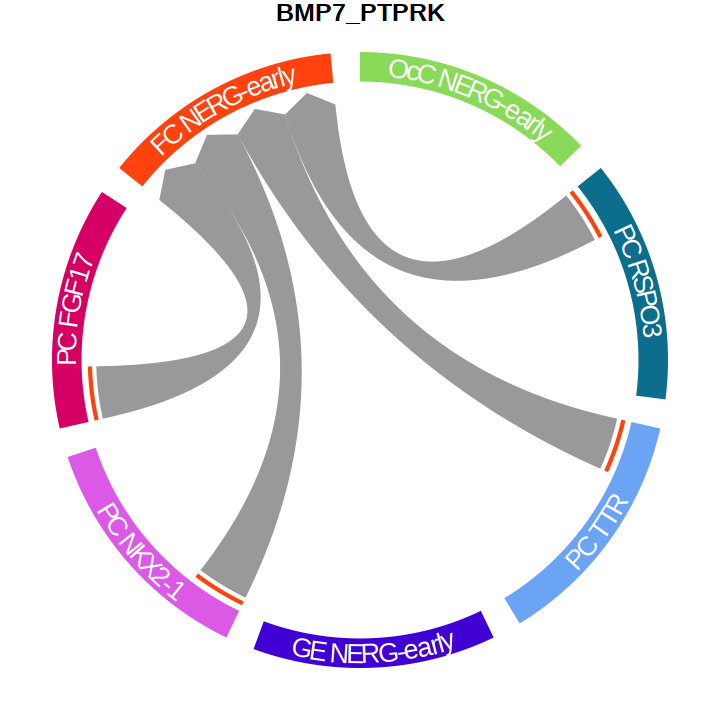

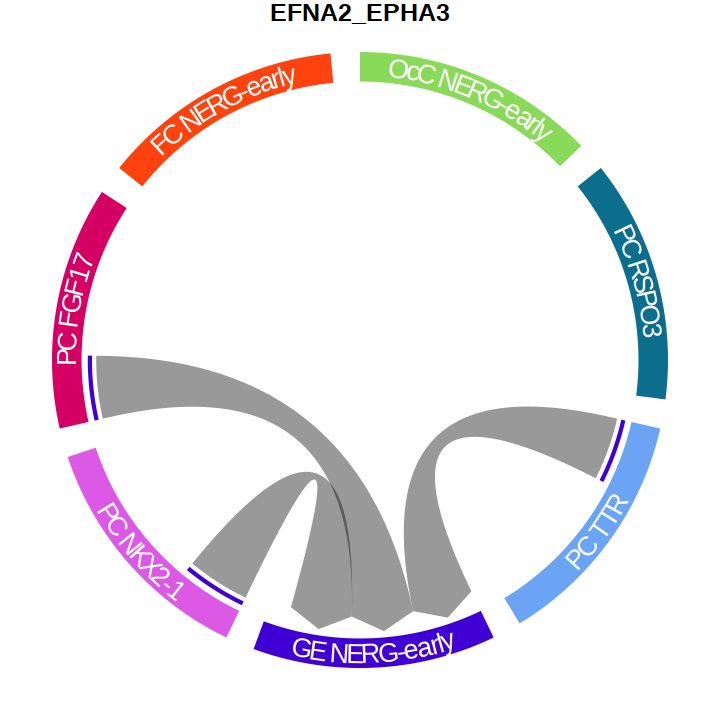

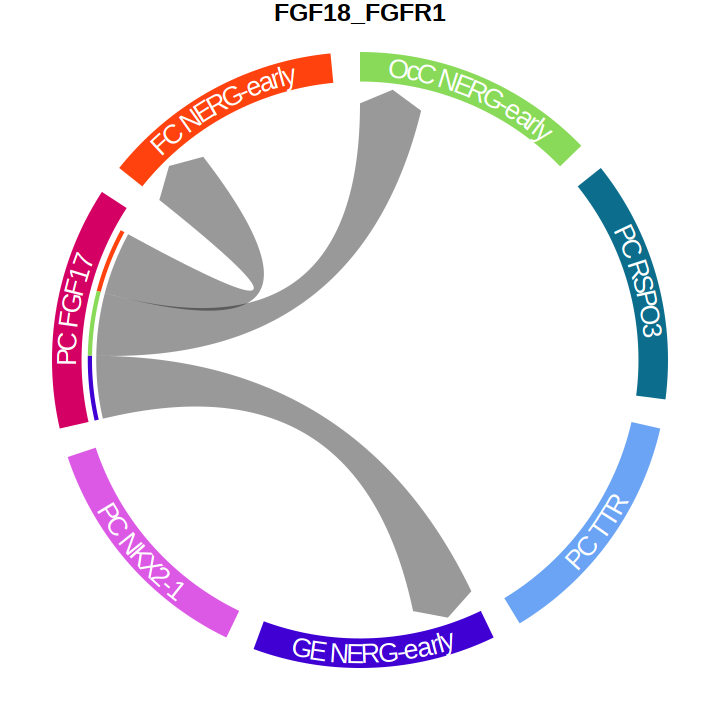

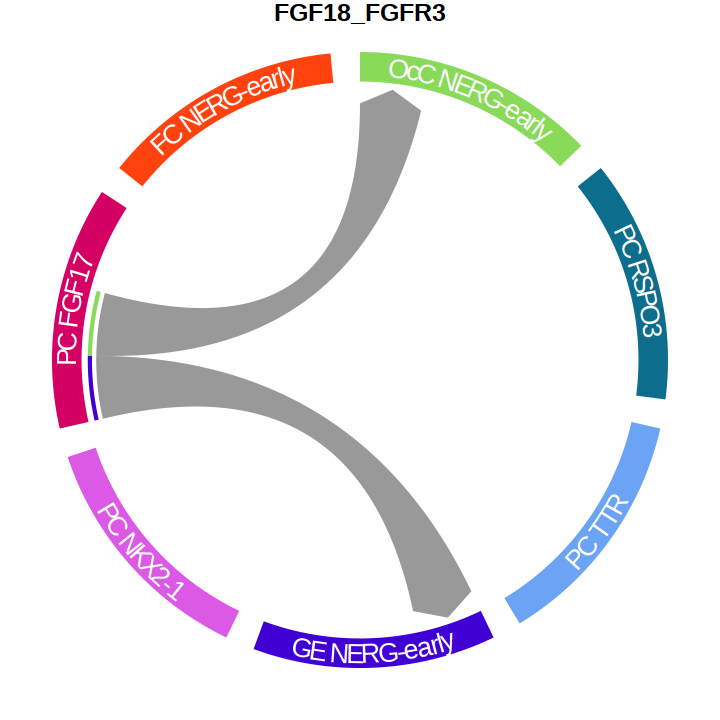

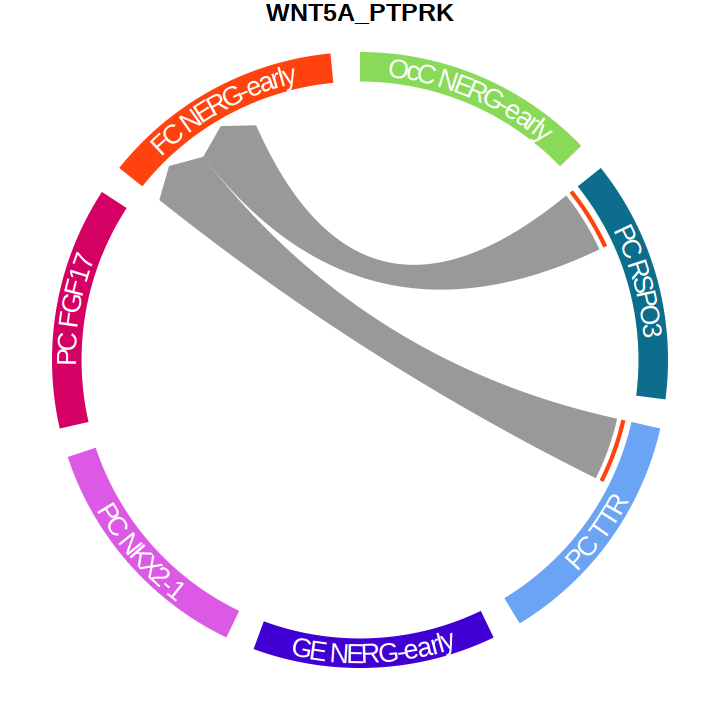

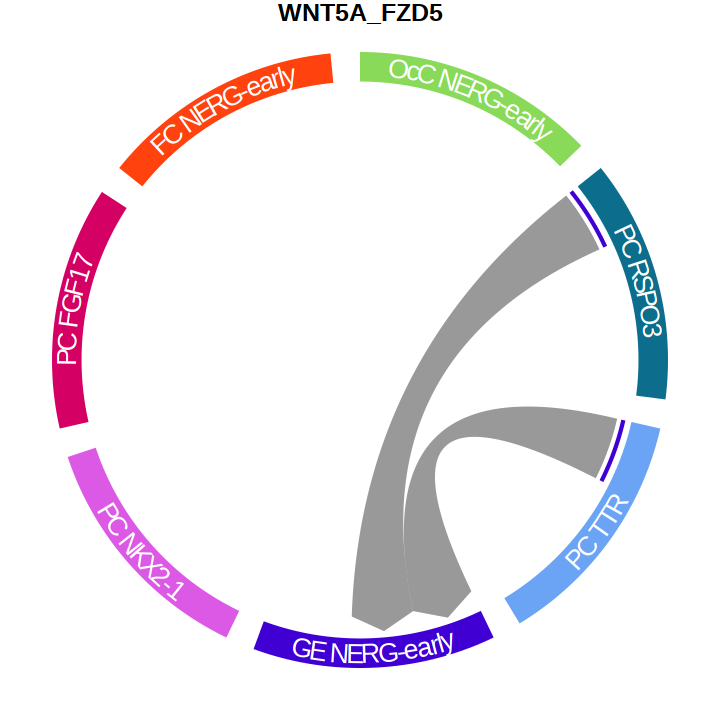

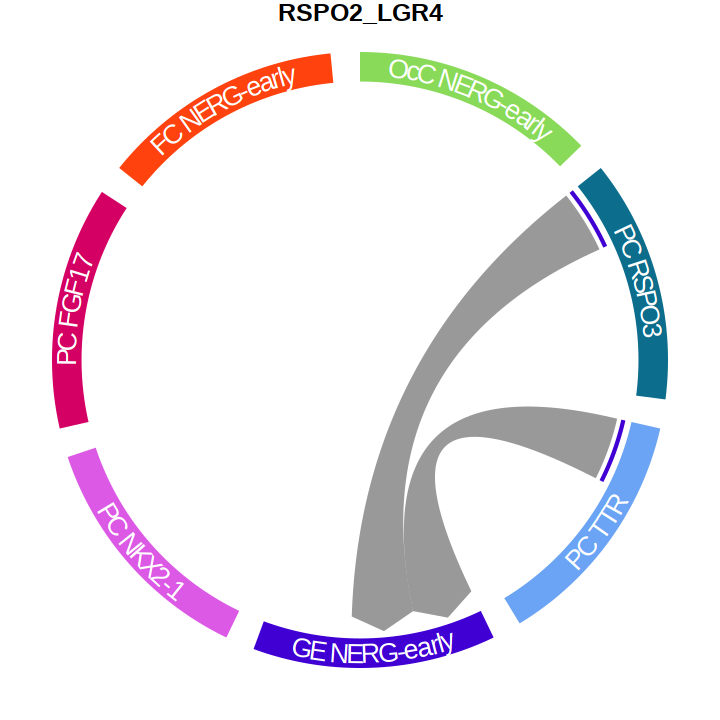

In [16]:
## Individual circular plot
allcls <- c("OcC NERG-early", "PC RSPO3", "PC TTR", "GE NERG-early", "PC NKX2-1", "PC FGF17", "FC NERG-early")
cls.cols <- c("#89DA59", "#0c6e8c", "#6ba4f4", "#4000d4", "#dc59e5", "#d40063", "#FF420E") %>% 
                setNames(., allcls)

mat_vis <- newmats
pairs <- c('BMP2_SMO', 'BMP7_PTPRK', 'EFNA2_EPHA3', 'FGF18_FGFR1', 'FGF18_FGFR3', 
           'WNT5A_PTPRK', 'WNT5A_FZD5', 'RSPO2_LGR4')
options(repr.plot.width=6, repr.plot.height=6, res = 600)
for (pair in pairs){
        pdata <- PreCircleData(mat = mat_vis, LR = pair, log10transfer = TRUE, maxp = 3, minp = NULL)
        PlotInterCircle_individual(pdata = pdata, output_dir = paste0("./report/", "sepcircle/"), 
                                   file_name = paste0("LR-circle-sep-", pair), 
                                   cluster.cols = cls.cols, cls.ord = allcls, 
                                   title_lab = pair,
                                  return.plot = TRUE)
}

In [17]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggsankey_0.0.99999  tibble_3.0.1        tidyr_1.1.3        
 [4] circlize_0.4.13     ggpubr_0.3.0        patchwork_1.0.0    
 [7] CellChat_1.1.3      bigmemory_4.6.1     Biobase_2.46.0     
[10] BiocGenerics_0.32.0 ggplot2_3.3.0       igraph_